<a href="https://colab.research.google.com/github/Wzhhhh0815/Learning/blob/master/%E8%AE%A1%E7%AE%97%E6%9C%BA%E8%A7%86%E8%A7%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [5]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-k4gkc2rm
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-k4gkc2rm
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Resolved https://github.com/d2l-ai/d2l-zh to commit b29df2a66b5569984330b936409045eb2c13ef29
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 79.1 MB/s eta 0:0

# 图像增广
:label:`sec_image_augmentation`

 :numref:`sec_alexnet`提到过大型数据集是成功应用深度神经网络的先决条件。
图像增广在对训练图像进行一系列的随机变化之后，生成相似但不同的训练样本，从而扩大了训练集的规模。
此外，应用图像增广的原因是，随机改变训练样本可以减少模型对某些属性的依赖，从而提高模型的泛化能力。
例如，我们可以以不同的方式裁剪图像，使感兴趣的对象出现在不同的位置，减少模型对于对象出现位置的依赖。
我们还可以调整亮度、颜色等因素来降低模型对颜色的敏感度。
可以说，图像增广技术对于AlexNet的成功是必不可少的。本节将讨论这项广泛应用于计算机视觉的技术。


In [9]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

## 常用的图像增广方法

在对常用图像增广方法的探索时，我们将使用下面这个尺寸为$400\times 500$的图像作为示例。


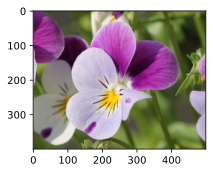

In [14]:
d2l.set_figsize()
img = d2l.Image.open('img/cat1.jpg')
d2l.plt.imshow(img);

大多数图像增广方法都具有一定的随机性。为了便于观察图像增广的效果，我们下面定义辅助函数`apply`。
此函数在输入图像`img`上多次运行图像增广方法`aug`并显示所有结果。


In [15]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### 翻转和裁剪

[**左右翻转图像**]通常不会改变对象的类别。这是最早且最广泛使用的图像增广方法之一。
接下来，我们使用`transforms`模块来创建`RandomFlipLeftRight`实例，这样就各有50%的几率使图像向左或向右翻转。


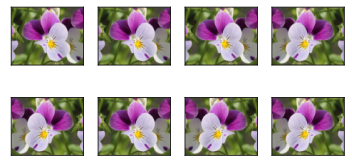

In [16]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

[**上下翻转图像**]不如左右图像翻转那样常用。但是，至少对于这个示例图像，上下翻转不会妨碍识别。接下来，我们创建一个`RandomFlipTopBottom`实例，使图像各有50%的几率向上或向下翻转。


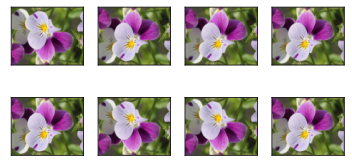

In [17]:
apply(img, torchvision.transforms.RandomVerticalFlip())

在我们使用的示例图像中，猫位于图像的中间，但并非所有图像都是这样。
在 :numref:`sec_pooling`中，我们解释了汇聚层可以降低卷积层对目标位置的敏感性。
另外，我们可以通过对图像进行随机裁剪，使物体以不同的比例出现在图像的不同位置。
这也可以降低模型对目标位置的敏感性。

下面的代码将[**随机裁剪**]一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5～2之间随机取值。
然后，区域的宽度和高度都被缩放到200像素。
在本节中（除非另有说明），$a$和$b$之间的随机数指的是在区间$[a, b]$中通过均匀采样获得的连续值。


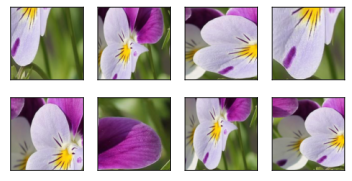

In [18]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### 改变颜色

另一种增广方法是改变颜色。
我们可以改变图像颜色的四个方面：亮度、对比度、饱和度和色调。
在下面的示例中，我们[**随机更改图像的亮度**]，随机值为原始图像的50%（$1-0.5$）到150%（$1+0.5$）之间。


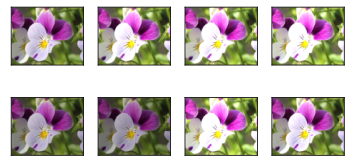

In [19]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

同样，我们可以[**随机更改图像的色调**]。


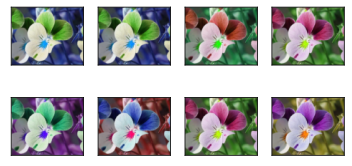

In [20]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

我们还可以创建一个`RandomColorJitter`实例，并设置如何同时[**随机更改图像的亮度（`brightness`）、对比度（`contrast`）、饱和度（`saturation`）和色调（`hue`）**]。


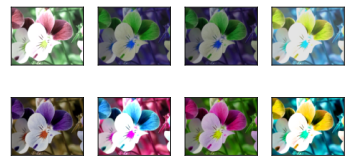

In [21]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### [**结合多种图像增广方法**]

在实践中，我们将结合多种图像增广方法。比如，我们可以通过使用一个`Compose`实例来综合上面定义的不同的图像增广方法，并将它们应用到每个图像。


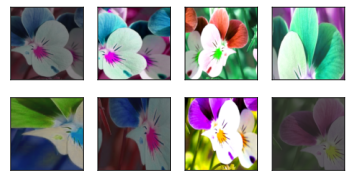

In [22]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

## [**使用图像增广进行训练**]

让我们使用图像增广来训练模型。
这里，我们使用CIFAR-10数据集，而不是我们之前使用的Fashion-MNIST数据集。
这是因为Fashion-MNIST数据集中对象的位置和大小已被规范化，而CIFAR-10数据集中对象的颜色和大小差异更明显。
CIFAR-10数据集中的前32个训练图像如下所示。


100%|██████████| 170498071/170498071 [00:03<00:00, 48604127.44it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


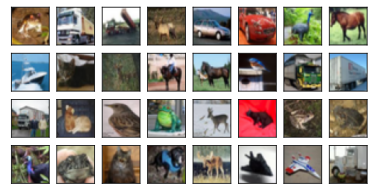

In [23]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，且在预测过程中不使用随机操作的图像增广。
在这里，我们[**只使用最简单的随机左右翻转**]。
此外，我们使用`ToTensor`实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0～1。


In [24]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

接下来，我们[**定义一个辅助函数，以便于读取图像和应用图像增广**]。PyTorch数据集提供的`transform`参数应用图像增广来转化图像。有关`DataLoader`的详细介绍，请参阅 :numref:`sec_fashion_mnist`。


In [25]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

### 多GPU训练

我们在CIFAR-10数据集上训练 :numref:`sec_resnet`中的ResNet-18模型。
回想一下 :numref:`sec_multi_gpu_concise`中对多GPU训练的介绍。
接下来，我们[**定义一个函数，使用多GPU对模型进行训练和评估**]。


In [26]:

def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [27]:

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

现在，我们可以[**定义`train_with_data_aug`函数，使用图像增广来训练模型**]。该函数获取所有的GPU，并使用Adam作为训练的优化算法，将图像增广应用于训练集，最后调用刚刚定义的用于训练和评估模型的`train_ch13`函数。


In [28]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

让我们使用基于随机左右翻转的图像增广来[**训练模型**]。


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


KeyboardInterrupt: ignored

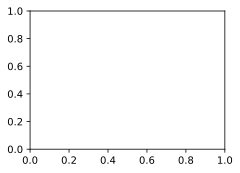

In [29]:
train_with_data_aug(train_augs, test_augs, net)

## 小结

* 图像增广基于现有的训练数据生成随机图像，来提高模型的泛化能力。
* 为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，而在预测过程中不使用带随机操作的图像增广。
* 深度学习框架提供了许多不同的图像增广方法，这些方法可以被同时应用。

## 练习

1. 在不使用图像增广的情况下训练模型：`train_with_data_aug(no_aug, no_aug)`。比较使用和不使用图像增广的训练结果和测试精度。这个对比实验能支持图像增广可以减轻过拟合的论点吗？为什么？
2. 在基于CIFAR-10数据集的模型训练中结合多种不同的图像增广方法。它能提高测试准确性吗？
3. 参阅深度学习框架的在线文档。它还提供了哪些其他的图像增广方法？


[Discussions](https://discuss.d2l.ai/t/2829)
